In [1]:
!nvidia-smi

Wed Aug 20 19:47:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:9B:00.0 Off |                    0 |
| N/A   42C    P0             82W /  700W |       1MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os, math, json, random
import numpy as np
import torch
from tqdm import tqdm
import plotly.graph_objects as go
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
# High-performance matmul on Ampere/Hopper
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `openfabric` has been saved to /home/bompilwar.r/.cache/huggingface/stored_tokens
Your token has been saved to /home/bompilwar.r/.cache/huggingface/token
Login successful.
The current active token is: `openfabric`
Using device: cuda


In [ ]:
# -------------------------
# CONFIG — edit model IDs here if needed
# 1B/3B are typically published under the 3.2 line; 8B under 3.1.
MODEL_IDS = {
    "llama_1b": "meta-llama/Llama-3.2-1B",
    "llama_3b": "meta-llama/Llama-3.2-3B",
    "llama_8b": "meta-llama/Llama-3.1-8B",
}
REVISION = None              # pin a commit if you want exact reproducibility
DTYPE = "bfloat16"           # "float16" if bf16 not supported
MAX_LENGTH = 256
BATCH_SIZE = 24              # starting guess; auto-downscales on OOM
SEED = 1337
OUTDIR = "RSA/artifacts"
SUBSETS = ["en", "hi"]
TEXT_COLUMN = "question"
LIMIT_PER_LANG = None        # e.g., 400 to cap for speed; None = full

os.makedirs(OUTDIR, exist_ok=True)

In [5]:
# -------------------------
# Utils

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

def _dtype_from_str(s):
    return {"bfloat16": torch.bfloat16, "float16": torch.float16}.get(s, torch.float32)

def load_ds(subset="en", split="test", text_col="question", limit=None):
    ds = load_dataset("CohereLabs/Global-MMLU-Lite", subset, split=split)
    if text_col not in ds.column_names:
        for cand in ["question","prompt","input","text"]:
            if cand in ds.column_names:
                text_col = cand; break
    texts = [str(x[text_col]).strip() for x in ds if str(x.get(text_col,"")).strip()]
    if limit: texts = texts[:limit]
    return texts

def load_model_tok(model_id, revision=None, dtype="bfloat16", device_map="auto"):
    def _dtype_from_str(s):
        return {"bfloat16": torch.bfloat16, "float16": torch.float16}.get(s, torch.float32)

    tok = AutoTokenizer.from_pretrained(model_id, revision=revision, use_fast=True)

    # >>> Fix: ensure a pad token exists <<<
    if tok.pad_token is None:
        # safest choice for decoder LMs
        tok.pad_token = tok.eos_token

    tok.padding_side = "right"
    tok.truncation_side = "left"

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        revision=revision,
        torch_dtype=_dtype_from_str(dtype),
        low_cpu_mem_usage=True,
        device_map=device_map,
    )
    # keep model's config consistent with tokenizer
    if getattr(model.config, "pad_token_id", None) is None or model.config.pad_token_id == -1:
        model.config.pad_token_id = tok.pad_token_id

    model.eval()
    print(f"[OK] {model_id}: pad_token_id={tok.pad_token_id}, eos_token_id={tok.eos_token_id}")
    return model, tok

In [6]:
# -------------------------
# Activation collection (final non-pad token at every layer) with OOM backoff

@torch.no_grad()
def collect_layer_mats(texts, model_id, revision=None, dtype=DTYPE, max_length=MAX_LENGTH,
                       batch_size=BATCH_SIZE):
    set_seed(SEED)
    model, tok = load_model_tok(model_id, revision=revision, dtype=dtype, device_map="auto")

    enc = tok(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"].pin_memory()
    attention_mask = enc["attention_mask"].pin_memory()

    N = input_ids.shape[0]
    L = model.config.num_hidden_layers
    per_layer_batches = {i: [] for i in range(1, L+1)}

    bs = batch_size
    i = 0
    pbar = tqdm(total=N, desc=f"{model_id} collect")
    while i < N:
        s, e = i, min(i+bs, N)
        try:
            ids  = input_ids[s:e].to(model.device, non_blocking=True)
            mask = attention_mask[s:e].to(model.device, non_blocking=True)

            out = model(input_ids=ids, attention_mask=mask,
                        output_hidden_states=True, use_cache=False)
            hs = out.hidden_states  # (embeds, layer1..layerL)
            last_idx = mask.sum(dim=1) - 1

            for li in range(1, L+1):
                H = hs[li]  # [B,T,D]
                idx = last_idx.view(-1,1,1).expand(H.size(0),1,H.size(-1))
                vecs = H.gather(1, idx).squeeze(1).to(torch.float32)  # [B,D]
                per_layer_batches[li].append(vecs.cpu())

            del out, hs, ids, mask
            torch.cuda.empty_cache()
            i = e
            pbar.update(e - s)

        except torch.cuda.OutOfMemoryError:
            torch.cuda.empty_cache()
            if bs == 1:
                raise
            bs = max(1, bs // 2)
            print(f"[OOM] Reducing batch_size to {bs} and retrying...")

    pbar.close()
    X_layers = {f"layer_{li}": torch.cat(per_layer_batches[li], 0).numpy()
                for li in range(1, L+1)}
    meta = dict(model_id=model_id, revision=revision, num_layers=L,
                dtype=dtype, max_length=max_length, texts_count=N)
    return X_layers, meta

def save_bundle(X_layers, meta, texts, base):
    np.savez_compressed(base + ".npz", **X_layers)
    with open(base + ".meta.json","w") as f: json.dump(meta, f, indent=2)
    with open(base + ".texts.json","w") as f: json.dump(texts, f, indent=2, ensure_ascii=False)


In [7]:
# -------------------------
# GPU metrics: CKA + RSA (Spearman) — vectorized + GPU-safe, same function names

import numpy as np
import torch

def to_dev(arr, device=device, dtype=torch.float32):
    t = torch.from_numpy(arr)
    if device != "cpu" and torch.cuda.is_available():
        return t.to(device=device, dtype=dtype, non_blocking=True)
    return t.to(dtype=dtype)

def center_zscore(X: torch.Tensor, center=True, zscore=True):
    if center:
        X = X - X.mean(0, keepdim=True)
    if zscore:
        X = X / (X.std(0, keepdim=True) + 1e-12)
    return X

# ---------- CKA ----------
@torch.no_grad()
def cka_linear(X: torch.Tensor, Y: torch.Tensor):
    Kx = X @ X.t()
    Ky = Y @ Y.t()
    n = Kx.shape[0]
    one = torch.ones((n, n), device=Kx.device) / n
    # Double-centering
    Kx = Kx - one @ Kx - Kx @ one + one @ Kx @ one
    Ky = Ky - one @ Ky - Ky @ one + one @ Ky @ one
    hsic = (Kx * Ky).sum()
    denom = torch.linalg.matrix_norm(Kx) * torch.linalg.matrix_norm(Ky) + 1e-12
    return hsic / denom  # scalar tensor

@torch.no_grad()
def cka_matrix_gpu(X_layers: dict, device=device):
    keys = list(X_layers.keys()); L = len(keys)
    mats = [center_zscore(to_dev(X_layers[k], device), True, True) for k in keys]
    out = torch.zeros((L, L), device=device, dtype=torch.float32)
    for i in range(L):
        Xi = mats[i]
        for j in range(L):
            out[i, j] = cka_linear(Xi, mats[j])
    return out.detach().cpu().numpy(), keys

@torch.no_grad()
def cka_cross_gpu(A_layers: dict, B_layers: dict, device=device):
    Ak, Bk = list(A_layers.keys()), list(B_layers.keys())
    XA = [center_zscore(to_dev(A_layers[k], device), True, True) for k in Ak]
    XB = [center_zscore(to_dev(B_layers[k], device), True, True) for k in Bk]
    out = torch.zeros((len(Ak), len(Bk)), device=device, dtype=torch.float32)
    for i in range(len(Ak)):
        Xi = XA[i]
        for j in range(len(Bk)):
            out[i, j] = cka_linear(Xi, XB[j])
    return out.detach().cpu().numpy(), Ak, Bk

# ---------- RSA (RDMs + vectorized Spearman) ----------
@torch.no_grad()
def rdm_cos(X: torch.Tensor):
    # Row-wise L2 normalization (per example)
    X = X / (X.norm(dim=1, keepdim=True) + 1e-12)
    S = X @ X.t()
    D = 1.0 - S
    D.fill_diagonal_(0.0)
    return D

@torch.no_grad()
def rdm_corr(X: torch.Tensor):
    # Row-wise mean-center, then row-wise L2 normalization
    X = X - X.mean(dim=1, keepdim=True)
    X = X / (X.norm(dim=1, keepdim=True) + 1e-12)
    S = X @ X.t()
    D = 1.0 - S
    D.fill_diagonal_(0.0)
    return D

@torch.no_grad()
def vec_upper(M: torch.Tensor) -> torch.Tensor:
    # Strict upper-triangle as 1D vector (on the same device as M)
    iu = torch.triu_indices(M.shape[0], M.shape[1], offset=1, device=M.device)
    return M[iu[0], iu[1]]

@torch.no_grad()
def _spearman_zrows(V: torch.Tensor) -> torch.Tensor:
    """
    Turn each row of V into z-scored rank features.
    V: [L, M] (each row is a vectorized RDM upper-triangle)
    Returns Z: [L, M]; Pearson on Z equals Spearman on original rows.
    Uses double argsort for ranks (ties get arbitrary order; fine for floats).
    """
    ranks = torch.argsort(torch.argsort(V, dim=1), dim=1).float()
    mean = ranks.mean(dim=1, keepdim=True)
    std  = ranks.std(dim=1, keepdim=True).clamp_min(1e-12)
    return (ranks - mean) / std

# (Kept for compatibility; not used by the vectorized RSA paths)
@torch.no_grad()
def _rankdata(v: torch.Tensor) -> torch.Tensor:
    sorter = torch.argsort(v)
    inv = torch.empty_like(sorter); inv[sorter] = torch.arange(v.numel(), device=v.device)
    vs = v[sorter]
    diffs = torch.diff(vs)
    idx = torch.where(diffs != 0)[0] + 1
    groups = torch.cat([torch.tensor([0], device=v.device), idx, torch.tensor([v.numel()], device=v.device)])
    ranks = torch.empty_like(inv, dtype=torch.float32)
    for a, b in zip(groups[:-1], groups[1:]):
        ranks[a:b] = (a + b - 1) / 2.0
    return ranks[inv]

@torch.no_grad()
def spearmanr_torch(v1: torch.Tensor, v2: torch.Tensor):
    if v1.numel() < 3 or v2.numel() < 3:
        return torch.tensor(0.0, device=v1.device)
    if torch.allclose(v1, v1[0]) or torch.allclose(v2, v2[0]):
        return torch.tensor(0.0, device=v1.device)
    r1 = _rankdata(v1); r2 = _rankdata(v2)
    r1 = (r1 - r1.mean()) / (r1.std() + 1e-12)
    r2 = (r2 - r2.mean()) / (r2.std() + 1e-12)
    return (r1 * r2).mean()

@torch.no_grad()
def rsa_matrix_gpu(X_layers: dict, metric="cosine", device=device):
    """
    Within-model RSA (Spearman) for all layer pairs, vectorized:
    1) Build RDM per layer, vectorize strict upper triangle -> rows of V [L, M]
    2) Convert rows to z-scored ranks -> Z [L, M]
    3) Pearson on Z equals Spearman on original -> S = (Z @ Z^T) / M
    """
    keys = list(X_layers.keys())
    V_list = []
    for k in keys:
        X = center_zscore(to_dev(X_layers[k], device), True, True)
        D = rdm_cos(X) if metric == "cosine" else rdm_corr(X)
        V_list.append(vec_upper(D))
    V = torch.stack(V_list, dim=0)              # [L, M]
    Z = _spearman_zrows(V)                      # [L, M]
    M = Z.shape[1]
    S = (Z @ Z.t()) / M                         # [L, L]
    return S.detach().cpu().numpy(), keys

@torch.no_grad()
def rsa_cross_gpu(A_layers: dict, B_layers: dict, metric="cosine", device=device):
    """
    Cross-model RSA (Spearman) for all layer pairs, vectorized:
    S = (ZA @ ZB^T) / M, where Z* are z-scored ranks of vectorized RDM upper triangles.
    """
    Akeys = list(A_layers.keys()); Bkeys = list(B_layers.keys())

    # A
    VA = []
    for k in Akeys:
        XA = center_zscore(to_dev(A_layers[k], device), True, True)
        DA = rdm_cos(XA) if metric == "cosine" else rdm_corr(XA)
        VA.append(vec_upper(DA))
    VA = torch.stack(VA, dim=0)                 # [LA, M]
    ZA = _spearman_zrows(VA)                    # [LA, M]

    # B
    VB = []
    for k in Bkeys:
        XB = center_zscore(to_dev(B_layers[k], device), True, True)
        DB = rdm_cos(XB) if metric == "cosine" else rdm_corr(XB)
        VB.append(vec_upper(DB))
    VB = torch.stack(VB, dim=0)                 # [LB, M]
    ZB = _spearman_zrows(VB)                    # [LB, M]

    M = ZA.shape[1]
    S = (ZA @ ZB.t()) / M                       # [LA, LB]
    return S.detach().cpu().numpy(), Akeys, Bkeys

In [8]:
# -------------------------
# Plotly + JSON export

def layer_ticks(n, prefix="L"): return [f"{prefix}{i}" for i in range(1, n+1)]

def show_heatmap(Z, x, y, title, colorscale="Viridis", out_html=None):
    # SAME NAME as before; now optionally saves HTML too.
    fig = go.Figure(data=go.Heatmap(z=Z, x=x, y=y, colorscale=colorscale))
    fig.update_layout(title=title, xaxis_title="Layer (X)", yaxis_title="Layer (Y)",
                      margin=dict(l=60, r=40, t=60, b=60))
    if out_html is not None:
        import os
        os.makedirs(os.path.dirname(out_html), exist_ok=True)
        fig.write_html(out_html, include_plotlyjs="cdn")
    fig.show()
    return fig  # harmless return

def save_heatmap_json(Z, x, y, metric, out_json, title="", model_a=None, model_b=None, info=None):
    # SAME NAME; ensures dirs exist
    import os, json, numpy as np
    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    payload = {
        "matrix": np.asarray(Z).tolist(),
        "x_labels": list(x),
        "y_labels": list(y),
        "metric": metric,
        "title": title,
        "model_a": model_a,
        "model_b": model_b,
        "info": info or {}
    }
    with open(out_json, "w") as f:
        json.dump(payload, f, indent=2)

In [9]:
# Shared store across cells (so later cells can add to it)
try:
    all_results
except NameError:
    all_results = {}  # (model_key, subset) -> (base, X_layers, meta, texts)

print("SUBSETS:", SUBSETS, "| OUTDIR:", OUTDIR)

SUBSETS: ['en', 'hi'] | OUTDIR: RSA/artifacts


In [ ]:
# Llama 1B
MODEL_KEY = "llama_1b"
MODEL_ID  = "meta-llama/Llama-3.2-1B"

for subset in SUBSETS:  # e.g., ["en", "hin"] or ["en", "hi"]
    print(f"\n[{MODEL_KEY}] subset={subset}")
    texts = load_ds(subset=subset, text_col=TEXT_COLUMN, limit=LIMIT_PER_LANG)
    X_layers, meta = collect_layer_mats(
        texts, model_id=MODEL_ID, revision=REVISION, dtype=DTYPE,
        max_length=MAX_LENGTH, batch_size=BATCH_SIZE
    )
    slug = MODEL_ID.replace("/", "_")
    BASE_DIR = os.path.join(OUTDIR, "models", slug, subset)
    ACT_DIR = os.path.join(BASE_DIR, "activations")
    os.makedirs(ACT_DIR, exist_ok=True)

    base = os.path.join(ACT_DIR, f"{slug}_{subset}_test")
    save_bundle(X_layers, {**meta, "subset": subset}, texts, base)
    all_results[(MODEL_KEY, subset)] = (base, X_layers, meta, texts)
    print(f"[OK] saved {base}.npz (+meta,+texts)")

# Optional: free some RAM/VRAM before the next model
del X_layers, meta, texts
import gc, torch; gc.collect(); torch.cuda.empty_cache()


In [ ]:
# Llama 3B
MODEL_KEY = "llama_3b"
MODEL_ID  = "meta-llama/Llama-3.2-3B"

for subset in SUBSETS:  # e.g., ["en", "hin"] or ["en", "hi"]
    print(f"\n[{MODEL_KEY}] subset={subset}")
    texts = load_ds(subset=subset, text_col=TEXT_COLUMN, limit=LIMIT_PER_LANG)
    X_layers, meta = collect_layer_mats(
        texts, model_id=MODEL_ID, revision=REVISION, dtype=DTYPE,
        max_length=MAX_LENGTH, batch_size=BATCH_SIZE
    )
    slug = MODEL_ID.replace("/", "_")
    BASE_DIR = os.path.join(OUTDIR, "models", slug, subset)
    ACT_DIR = os.path.join(BASE_DIR, "activations")
    os.makedirs(ACT_DIR, exist_ok=True)

    base = os.path.join(ACT_DIR, f"{slug}_{subset}_test")
    save_bundle(X_layers, {**meta, "subset": subset}, texts, base)
    all_results[(MODEL_KEY, subset)] = (base, X_layers, meta, texts)
    print(f"[OK] saved {base}.npz (+meta,+texts)")

del X_layers, meta, texts
import gc, torch; gc.collect(); torch.cuda.empty_cache()

In [ ]:
# Llama 8B
MODEL_KEY = "llama_8b"
MODEL_ID  = "meta-llama/Llama-3.1-8B"

for subset in SUBSETS:  # e.g., ["en", "hin"] or ["en", "hi"]
    print(f"\n[{MODEL_KEY}] subset={subset}")
    texts = load_ds(subset=subset, text_col=TEXT_COLUMN, limit=LIMIT_PER_LANG)
    X_layers, meta = collect_layer_mats(
        texts, model_id=MODEL_ID, revision=REVISION, dtype=DTYPE,
        max_length=MAX_LENGTH, batch_size=BATCH_SIZE
    )
    slug = MODEL_ID.replace("/", "_")
    BASE_DIR = os.path.join(OUTDIR, "models", slug, subset)
    ACT_DIR = os.path.join(BASE_DIR, "activations")
    os.makedirs(ACT_DIR, exist_ok=True)

    base = os.path.join(ACT_DIR, f"{slug}_{subset}_test")
    save_bundle(X_layers, {**meta, "subset": subset}, texts, base)
    all_results[(MODEL_KEY, subset)] = (base, X_layers, meta, texts)
    print(f"[OK] saved {base}.npz (+meta,+texts)")

del X_layers, meta, texts
import gc, torch; gc.collect(); torch.cuda.empty_cache()


Within: meta-llama/Llama-3.2-1B [en]


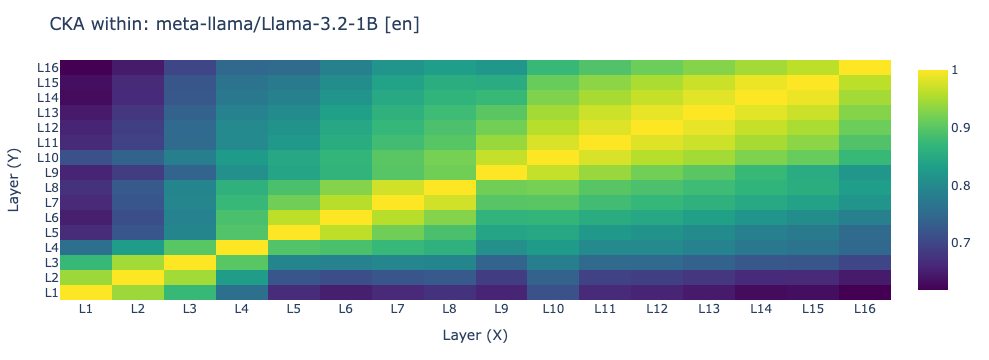

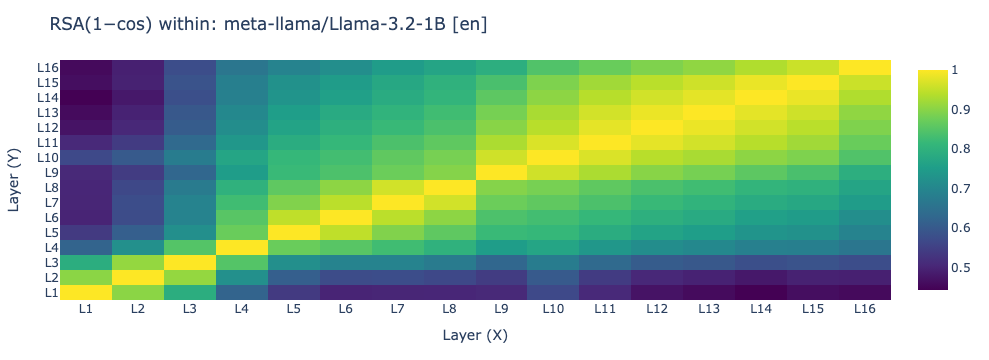

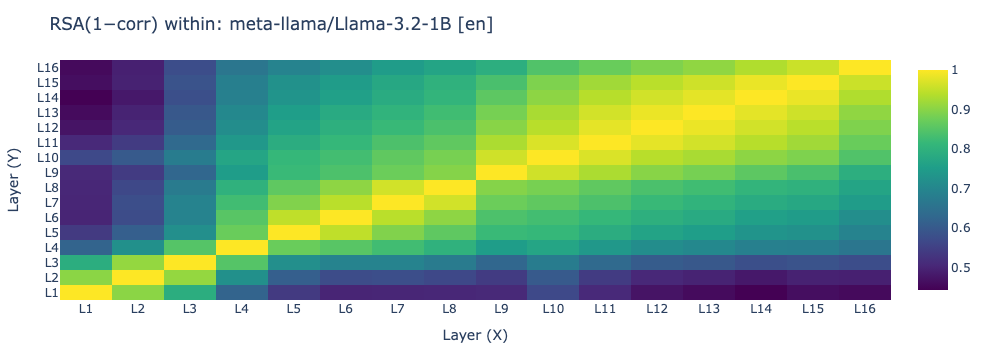


Within: meta-llama/Llama-3.2-1B [hi]


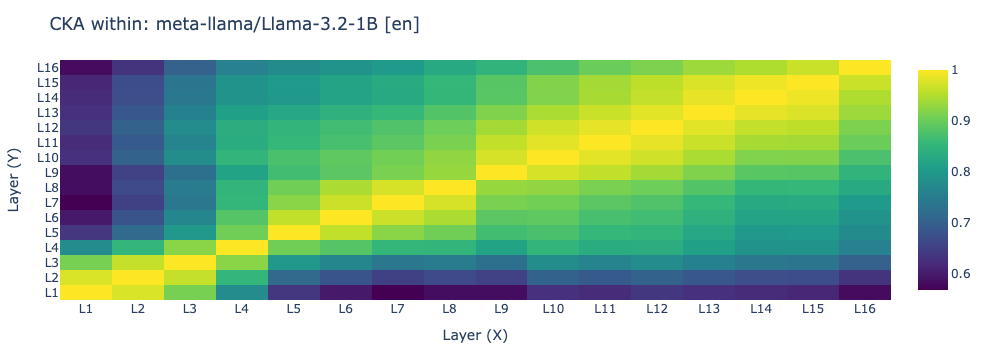

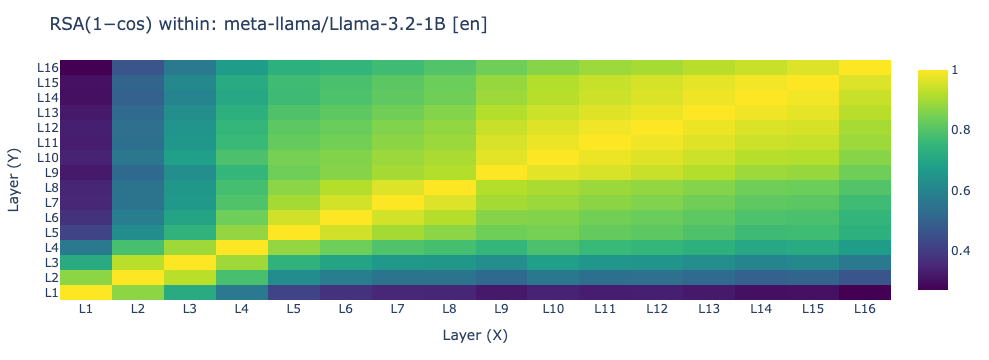

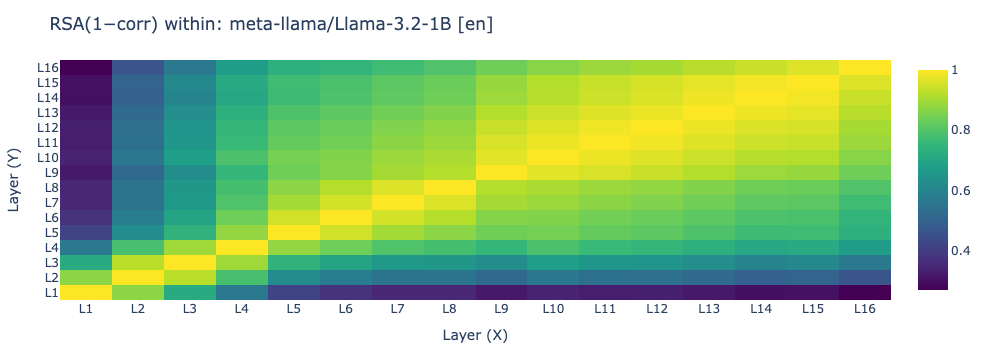


Within: meta-llama/Llama-3.2-3B [en]


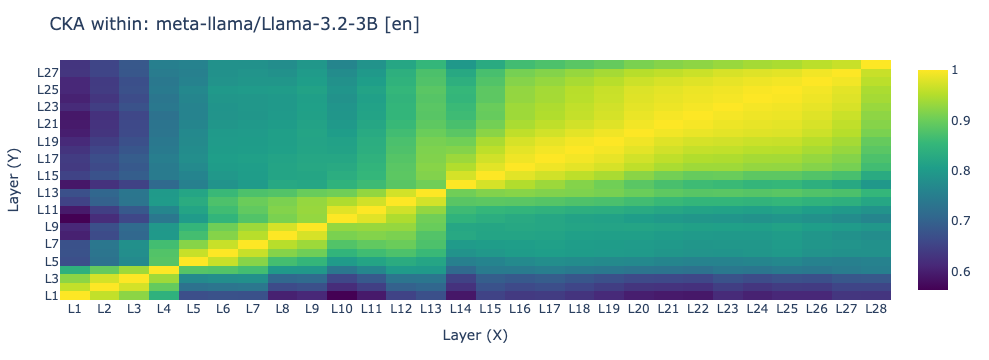

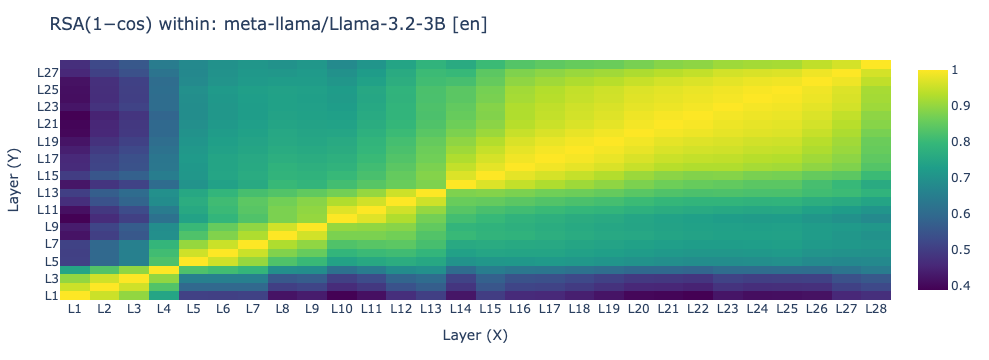

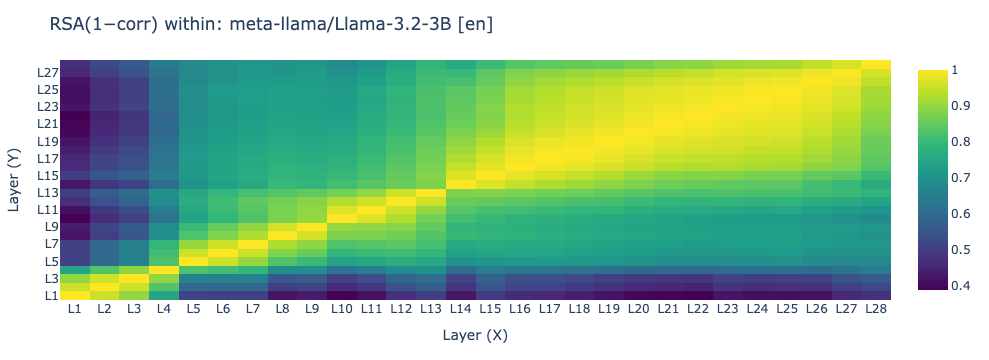


Within: meta-llama/Llama-3.2-3B [hi]


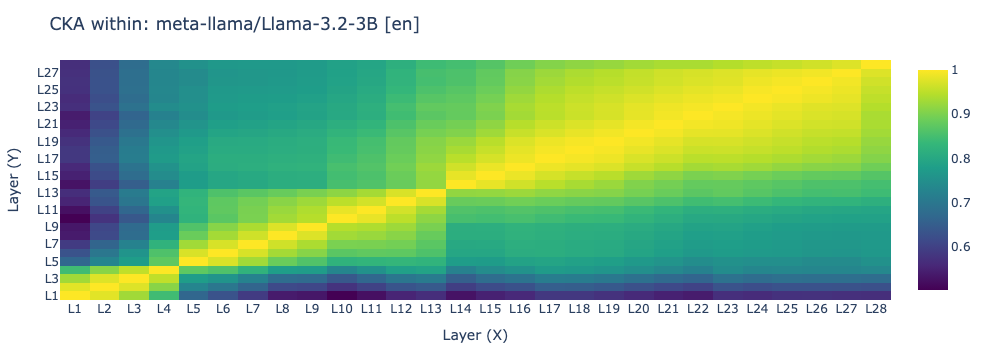

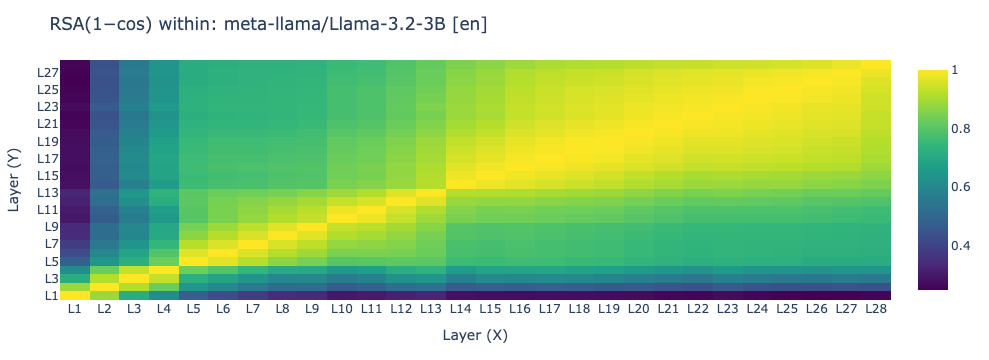

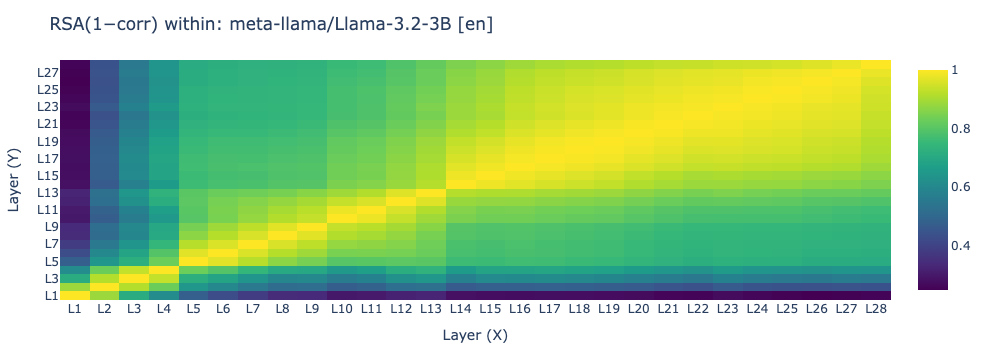


Within: meta-llama/Llama-3.1-8B [en]


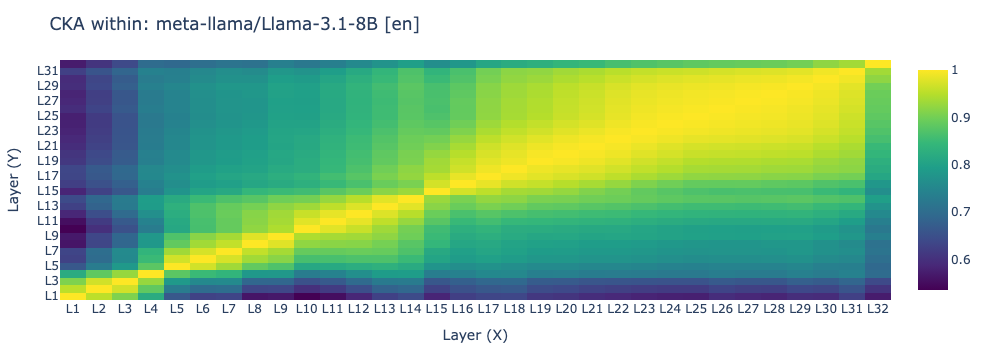

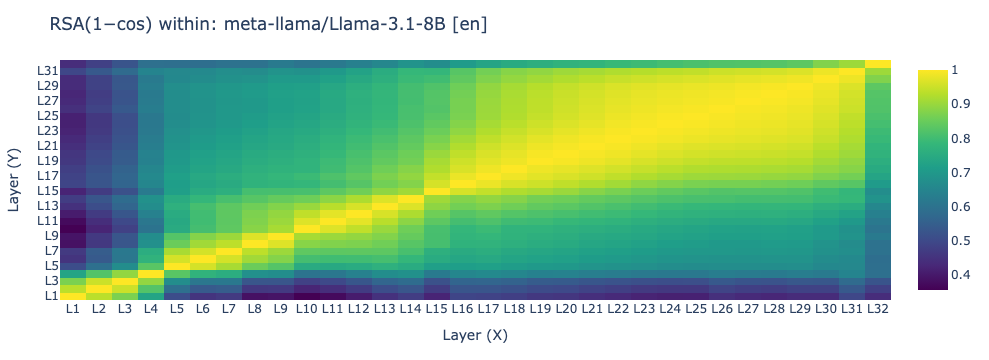

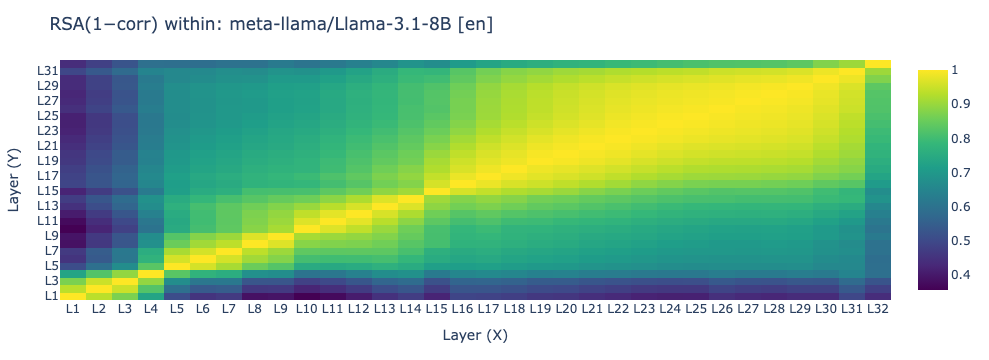


Within: meta-llama/Llama-3.1-8B [hi]


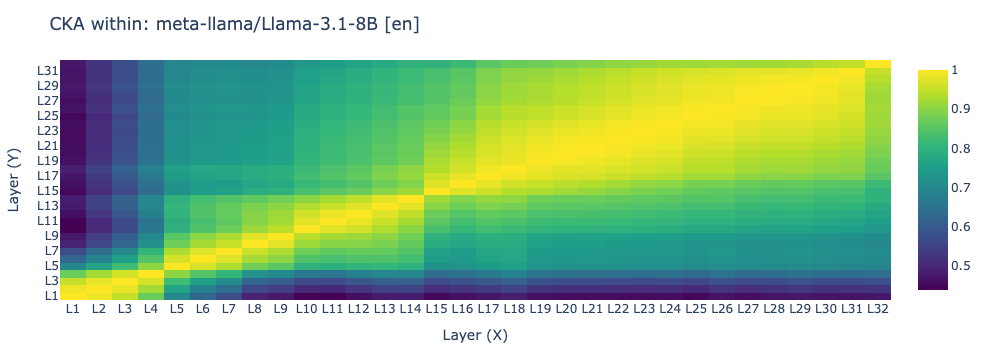

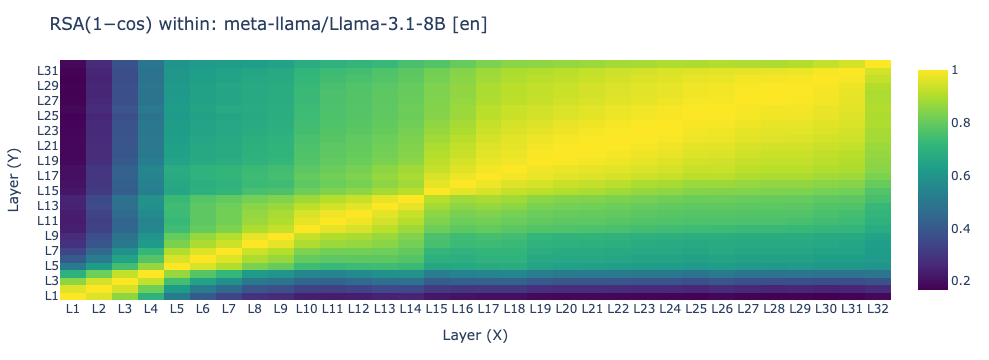

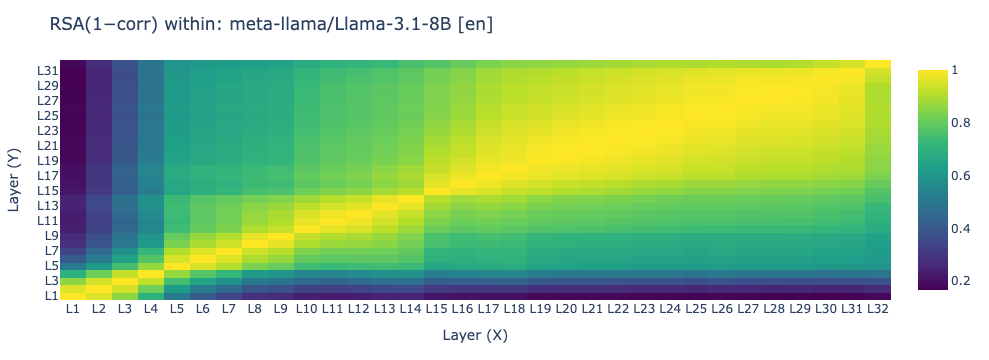

In [13]:
# -------------------------
# 2) Within-model heatmaps per (model, language)

for (mkey, subset), (base, X_layers, meta, _) in all_results.items():
    print(f"\nWithin: {meta['model_id']} [{subset}]")
    slug = meta["model_id"].replace("/", "_")
    subset = meta.get("subset", "en")  # or your current subset variable
    BASE_DIR = os.path.join(OUTDIR, "models", slug, subset)
    WITHIN_DIR = os.path.join(BASE_DIR, "heatmaps", "within")
    os.makedirs(WITHIN_DIR, exist_ok=True)

    xt = layer_ticks(len(X_layers)); yt = xt

    # CKA
    cka, _ = cka_matrix_gpu(X_layers)
    save_heatmap_json(cka, xt, yt, "cka", os.path.join(WITHIN_DIR, "CKA.json"),
                      title=f"CKA within: {meta['model_id']} [{subset}]", model_a=meta["model_id"])
    show_heatmap(cka, xt, yt, f"CKA within: {meta['model_id']} [{subset}]",
                out_html=os.path.join(WITHIN_DIR, "CKA.html"))

    # RSA (1−cos)
    rsa_cos, _ = rsa_matrix_gpu(X_layers, metric="cosine")
    save_heatmap_json(rsa_cos, xt, yt, "rsa_cos", os.path.join(WITHIN_DIR, "RSA_cos.json"),
                      title=f"RSA(1−cos) within", model_a=meta["model_id"])
    show_heatmap(rsa_cos, xt, yt, f"RSA(1−cos) within: {meta['model_id']} [{subset}]",
                out_html=os.path.join(WITHIN_DIR, "RSA_cos.html"))

    # RSA (1−corr)
    rsa_corr, _ = rsa_matrix_gpu(X_layers, metric="correlation")
    save_heatmap_json(rsa_corr, xt, yt, "rsa_corr", os.path.join(WITHIN_DIR, "RSA_corr.json"),
                      title=f"RSA(1−corr) within", model_a=meta["model_id"])
    show_heatmap(rsa_corr, xt, yt, f"RSA(1−corr) within: {meta['model_id']} [{subset}]",
                out_html=os.path.join(WITHIN_DIR, "RSA_corr.html"))

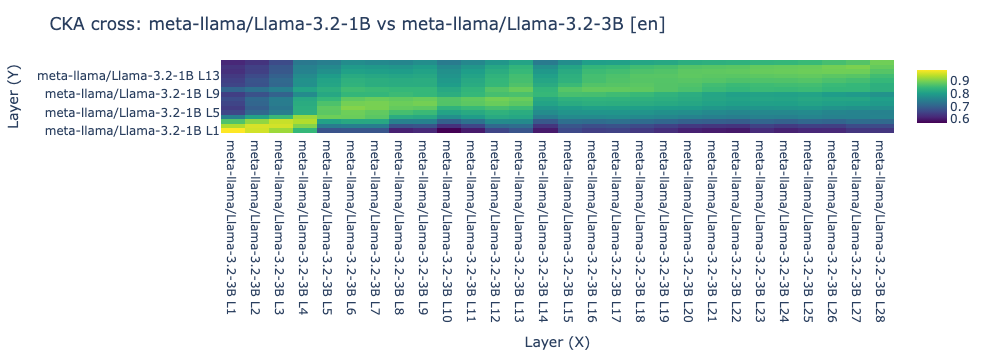

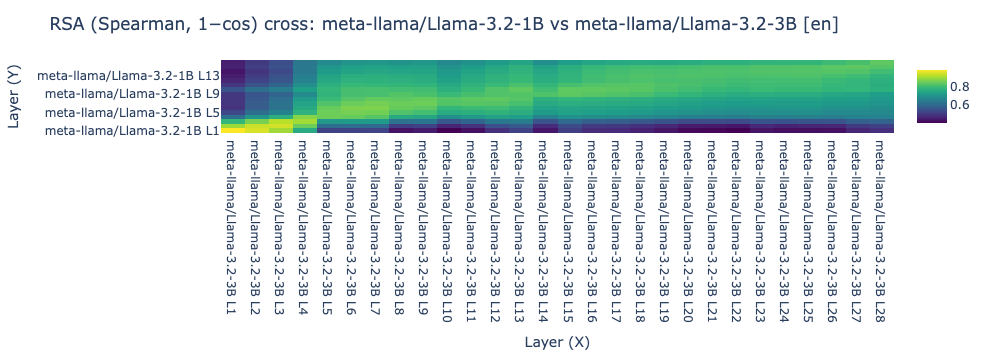

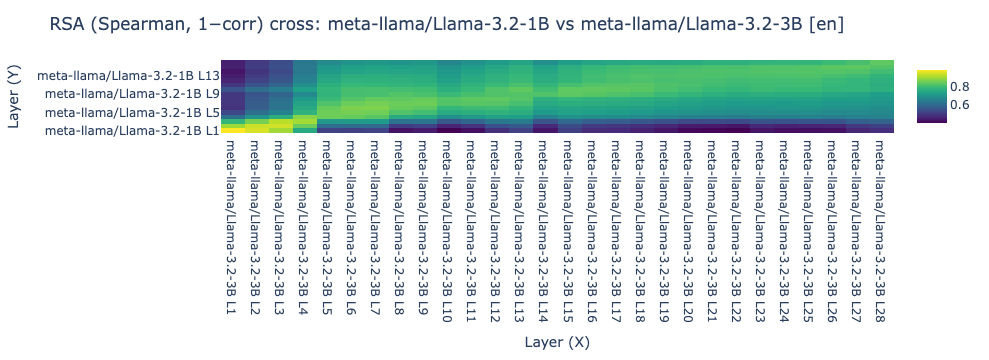

[OK] Saved cross heatmaps to: RSA/artifacts/cross/en/meta-llama_Llama-3.2-1B_X_meta-llama_Llama-3.2-3B


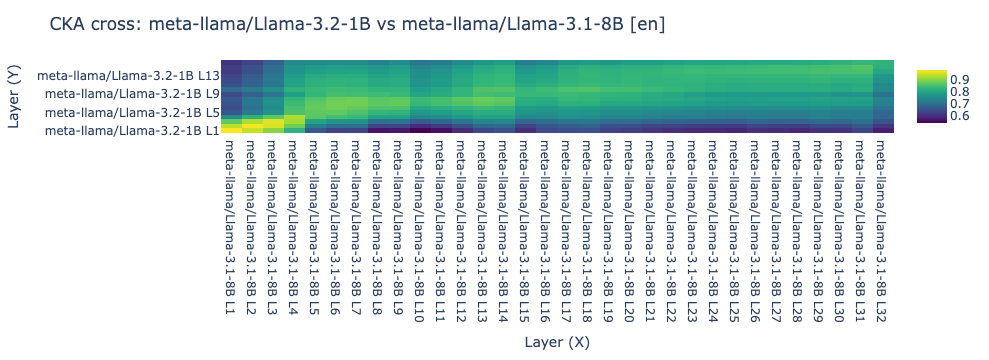

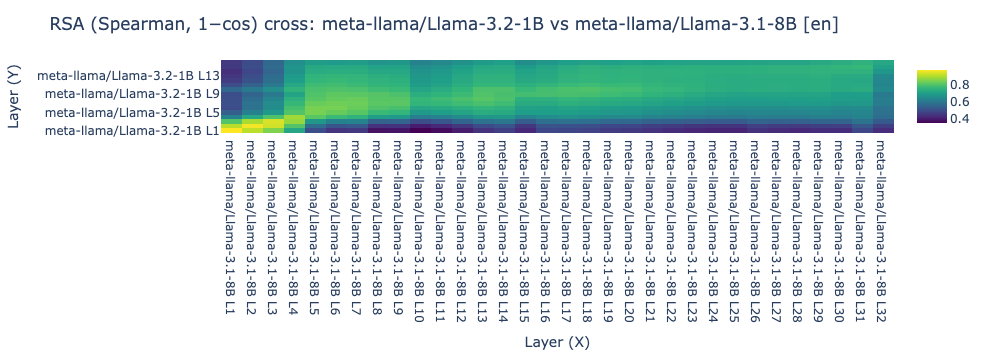

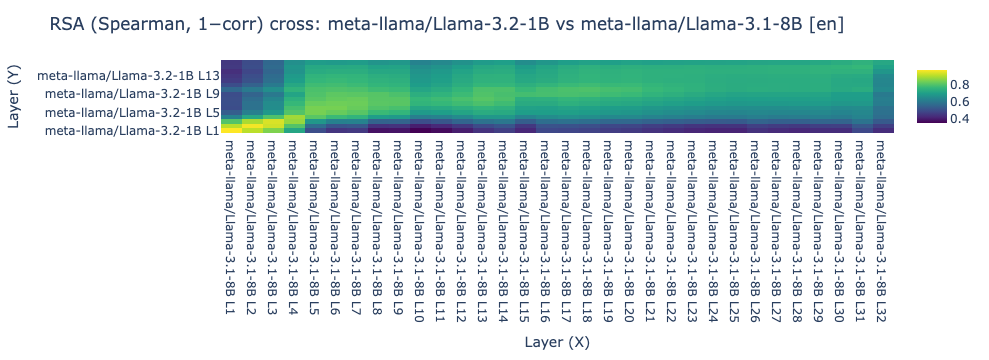

[OK] Saved cross heatmaps to: RSA/artifacts/cross/en/meta-llama_Llama-3.2-1B_X_meta-llama_Llama-3.1-8B


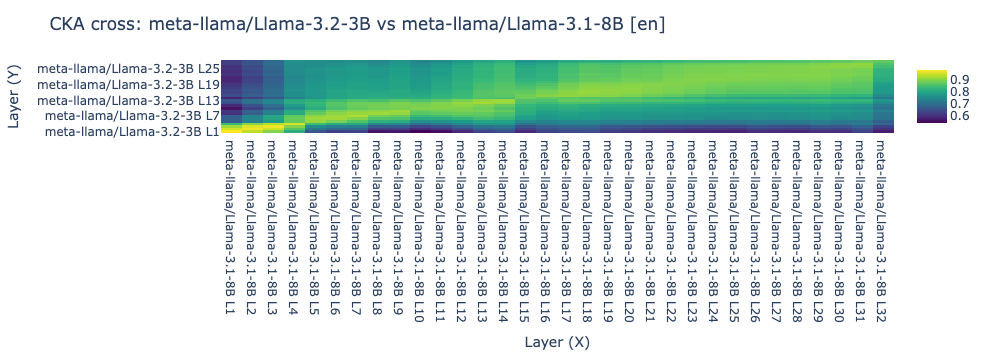

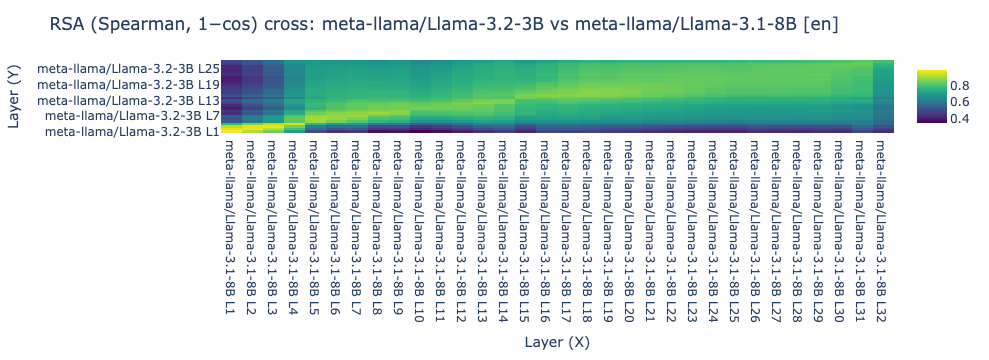

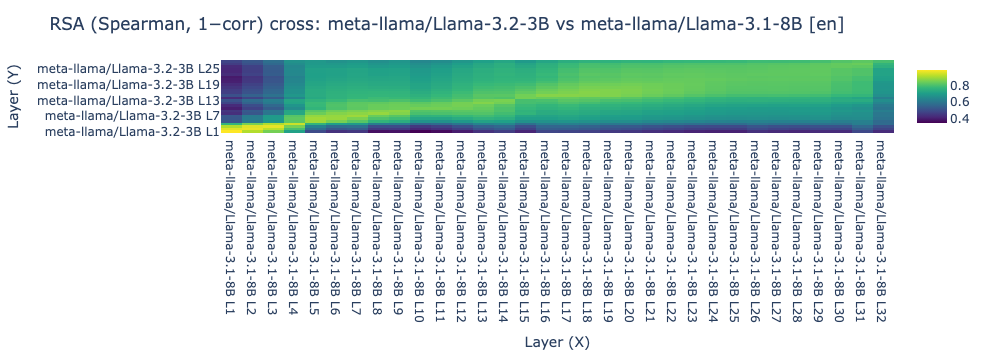

[OK] Saved cross heatmaps to: RSA/artifacts/cross/en/meta-llama_Llama-3.2-3B_X_meta-llama_Llama-3.1-8B


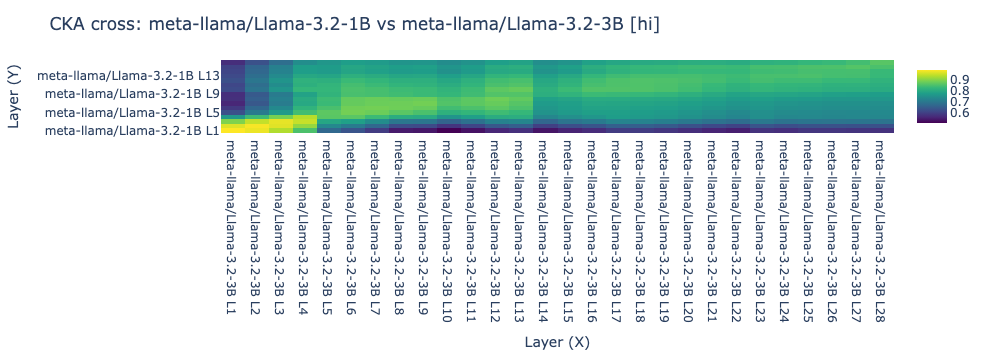

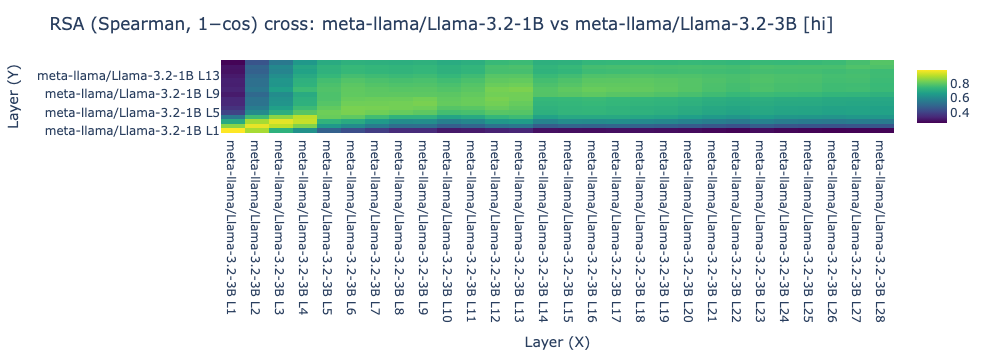

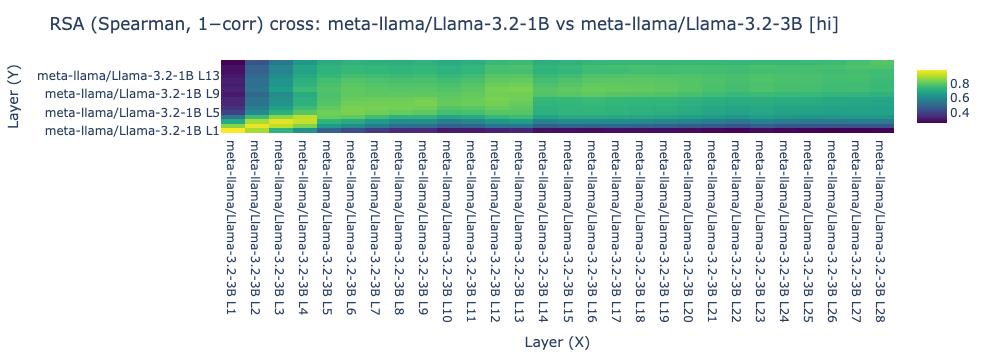

[OK] Saved cross heatmaps to: RSA/artifacts/cross/hi/meta-llama_Llama-3.2-1B_X_meta-llama_Llama-3.2-3B


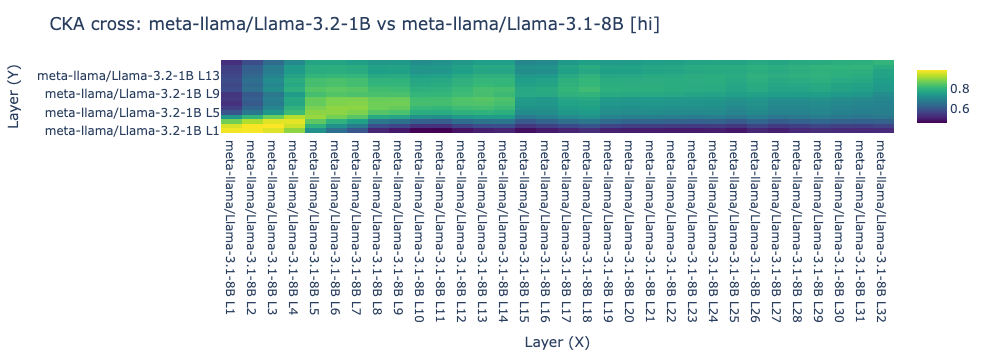

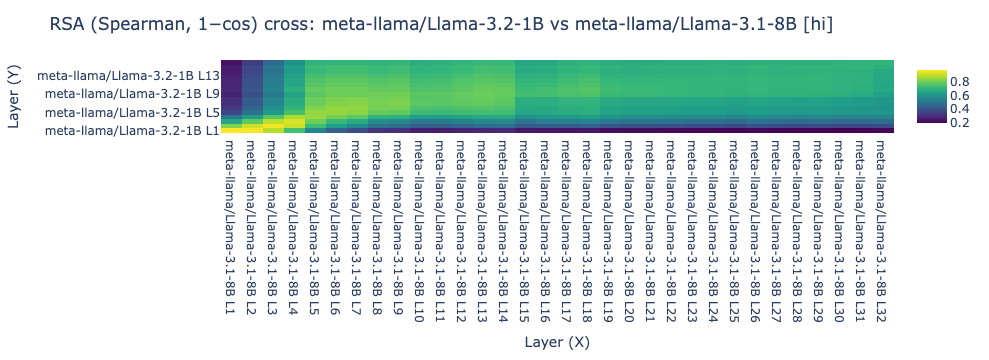

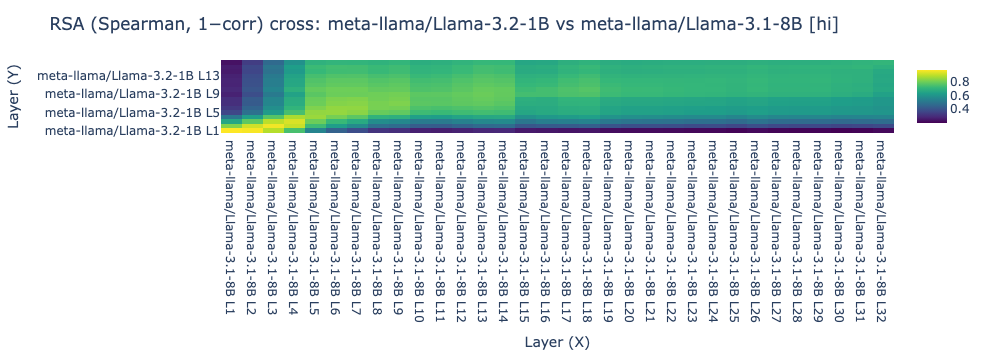

[OK] Saved cross heatmaps to: RSA/artifacts/cross/hi/meta-llama_Llama-3.2-1B_X_meta-llama_Llama-3.1-8B


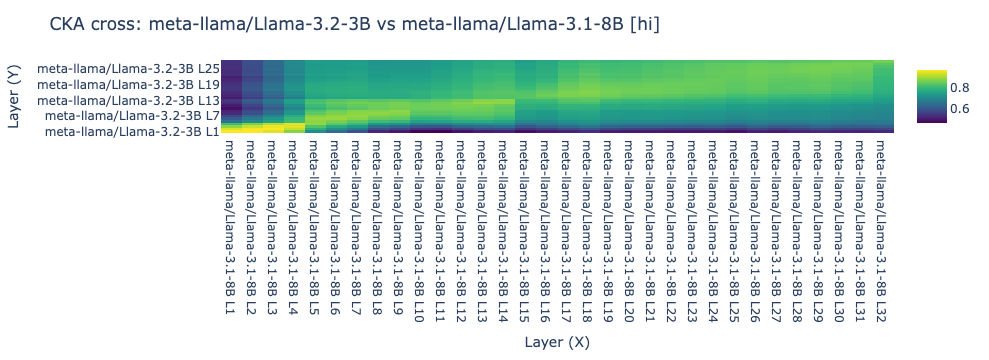

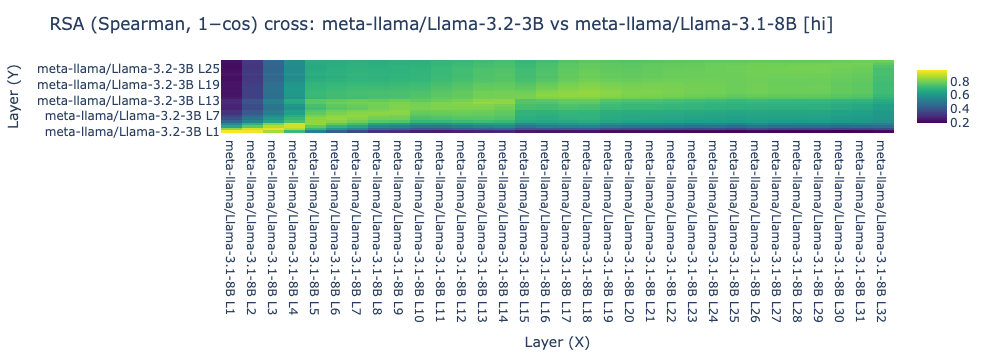

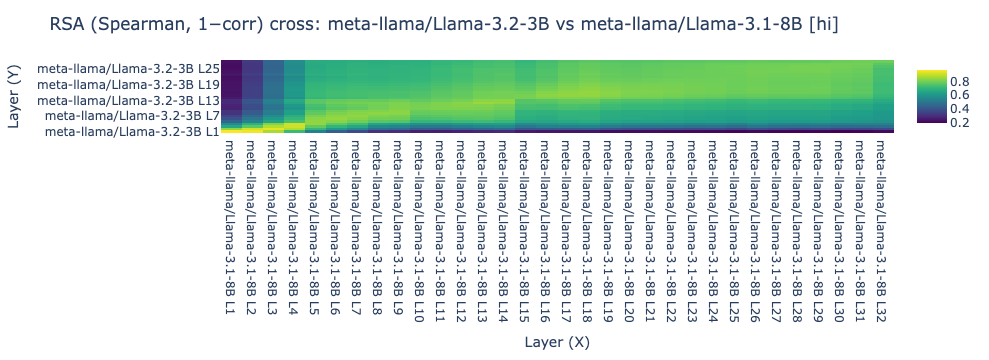

[OK] Saved cross heatmaps to: RSA/artifacts/cross/hi/meta-llama_Llama-3.2-3B_X_meta-llama_Llama-3.1-8B


In [14]:
# -------------------------
# 3) Cross-model heatmaps (same language) for all pairs among 1B/3B/8B

import os, itertools

pairs = list(itertools.combinations(MODEL_IDS.keys(), 2))  # e.g., ("llama_1b","llama_3b"), ...

for subset in SUBSETS:
    for A_key, B_key in pairs:
        # Unpack from the cache built in the per-model cells
        try:
            A_base, A_layers, A_meta, _ = all_results[(A_key, subset)]
            B_base, B_layers, B_meta, _ = all_results[(B_key, subset)]
        except KeyError as e:
            print(f"[SKIP] Missing {e} in all_results. Run the per-model cell for that (model, subset) first.")
            continue

        # Output directory
        slug_a = A_meta["model_id"].replace("/", "_")
        slug_b = B_meta["model_id"].replace("/", "_")
        PAIR_DIR = os.path.join(OUTDIR, "cross", subset, f"{slug_a}_X_{slug_b}")
        os.makedirs(PAIR_DIR, exist_ok=True)

        # Axis labels
        nA = len(A_layers)
        nB = len(B_layers)
        xt = [f"{B_meta['model_id']} L{j}" for j in range(1, nB + 1)]
        yt = [f"{A_meta['model_id']} L{i}" for i in range(1, nA + 1)]

        # ---- CKA cross
        cka, _, _ = cka_cross_gpu(A_layers, B_layers)
        save_heatmap_json(
            cka, xt, yt, "cka",
            os.path.join(PAIR_DIR, "CKA.json"),
            title=f"CKA cross [{subset}]",
            model_a=A_meta["model_id"], model_b=B_meta["model_id"]
        )
        show_heatmap(
            cka, xt, yt,
            f"CKA cross: {A_meta['model_id']} vs {B_meta['model_id']} [{subset}]",
            out_html=os.path.join(PAIR_DIR, "CKA.html")
        )

        # ---- RSA cross (1 − cosine)
        rsa_cos, _, _ = rsa_cross_gpu(A_layers, B_layers, metric="cosine")
        save_heatmap_json(
            rsa_cos, xt, yt, "rsa_cos",
            os.path.join(PAIR_DIR, "RSA_cos.json"),
            title=f"RSA(1−cos) cross [{subset}]",
            model_a=A_meta["model_id"], model_b=B_meta["model_id"]
        )
        show_heatmap(
            rsa_cos, xt, yt,
            f"RSA (Spearman, 1−cos) cross: {A_meta['model_id']} vs {B_meta['model_id']} [{subset}]",
            out_html=os.path.join(PAIR_DIR, "RSA_cos.html")
        )

        # ---- RSA cross (1 − correlation)
        rsa_corr, _, _ = rsa_cross_gpu(A_layers, B_layers, metric="correlation")
        save_heatmap_json(
            rsa_corr, xt, yt, "rsa_corr",
            os.path.join(PAIR_DIR, "RSA_corr.json"),
            title=f"RSA(1−corr) cross [{subset}]",
            model_a=A_meta["model_id"], model_b=B_meta["model_id"]
        )
        show_heatmap(
            rsa_corr, xt, yt,
            f"RSA (Spearman, 1−corr) cross: {A_meta['model_id']} vs {B_meta['model_id']} [{subset}]",
            out_html=os.path.join(PAIR_DIR, "RSA_corr.html")
        )

        print(f"[OK] Saved cross heatmaps to: {PAIR_DIR}")


In [15]:
# -------------------------
# 4) List exported files
import glob, pandas as pd
files = sorted(glob.glob(os.path.join(OUTDIR, "*")))
pd.DataFrame({"file": files})

file
0   RSA/artifacts/cross
1  RSA/artifacts/models

In [ ]:
# GPT-OSS 120B — activations (EN & HIN), bf16, batch_size=4

MODEL_KEY = "gptoss_120b"
MODEL_ID  = "openai/gpt-oss-120b"

LOCAL_BATCH_SIZE = 4  # as requested

for subset in SUBSETS:
    print(f"\n[{MODEL_KEY}] subset={subset}")
    texts = load_ds(subset=subset, text_col=TEXT_COLUMN, limit=LIMIT_PER_LANG)

    X_layers, meta = collect_layer_mats(
        texts,
        model_id=MODEL_ID,
        revision=REVISION,
        dtype=DTYPE,                 # keep "bfloat16"
        max_length=MAX_LENGTH,
        batch_size=LOCAL_BATCH_SIZE
    )
    meta["subset"] = subset

    slug = MODEL_ID.replace("/", "_")
    BASE_DIR = os.path.join(OUTDIR, "models", slug, subset)
    ACT_DIR  = os.path.join(BASE_DIR, "activations")
    os.makedirs(ACT_DIR, exist_ok=True)

    base = os.path.join(ACT_DIR, f"{slug}_{subset}_test")
    save_bundle(X_layers, meta, texts, base)
    all_results[(MODEL_KEY, subset)] = (base, X_layers, meta, texts)
    print(f"[OK] saved {base}.npz (+meta,+texts)")

del X_layers, meta, texts
import gc, torch; gc.collect(); torch.cuda.empty_cache()


In [ ]:
# Within-model heatmaps: GPT-OSS 20B & 120B

for model_key in ["gptoss_20b", "gptoss_120b"]:
    for subset in SUBSETS:
        if (model_key, subset) not in all_results:
            print(f"[SKIP] missing activations for {(model_key, subset)}")
            continue

        base, X_layers, meta, _ = all_results[(model_key, subset)]
        slug = meta["model_id"].replace("/", "_")
        BASE_DIR   = os.path.join(OUTDIR, "models", slug, subset)
        WITHIN_DIR = os.path.join(BASE_DIR, "heatmaps", "within")
        os.makedirs(WITHIN_DIR, exist_ok=True)

        xt = layer_ticks(len(X_layers)); yt = xt

        # CKA
        cka, _ = cka_matrix_gpu(X_layers)
        save_heatmap_json(
            cka, xt, yt, "cka",
            os.path.join(WITHIN_DIR, "CKA.json"),
            title=f"CKA within: {meta['model_id']} [{subset}]",
            model_a=meta["model_id"]
        )
        show_heatmap(
            cka, xt, yt,
            f"CKA within: {meta['model_id']} [{subset}]",
            out_html=os.path.join(WITHIN_DIR, "CKA.html")
        )

        # RSA (1 − cosine)
        rsa_cos, _ = rsa_matrix_gpu(X_layers, metric="cosine")
        save_heatmap_json(
            rsa_cos, xt, yt, "rsa_cos",
            os.path.join(WITHIN_DIR, "RSA_cos.json"),
            title=f"RSA(1−cos) within: {meta['model_id']} [{subset}]",
            model_a=meta["model_id"]
        )
        show_heatmap(
            rsa_cos, xt, yt,
            f"RSA (Spearman, 1−cos) within: {meta['model_id']} [{subset}]",
            out_html=os.path.join(WITHIN_DIR, "RSA_cos.html")
        )

        # RSA (1 − correlation)
        rsa_corr, _ = rsa_matrix_gpu(X_layers, metric="correlation")
        save_heatmap_json(
            rsa_corr, xt, yt, "rsa_corr",
            os.path.join(WITHIN_DIR, "RSA_corr.json"),
            title=f"RSA(1−corr) within: {meta['model_id']} [{subset}]",
            model_a=meta["model_id"]
        )
        show_heatmap(
            rsa_corr, xt, yt,
            f"RSA (Spearman, 1−corr) within: {meta['model_id']} [{subset}]",
            out_html=os.path.join(WITHIN_DIR, "RSA_corr.html")
        )

        print(f"[OK] within heatmaps → {WITHIN_DIR}")


In [ ]:
# Cross-model heatmaps: GPT-OSS 20B vs 120B (same language only)

A_KEY, B_KEY = "gptoss_20b", "gptoss_120b"

for subset in SUBSETS:
    if (A_KEY, subset) not in all_results or (B_KEY, subset) not in all_results:
        print(f"[SKIP] need both {(A_KEY, subset)} and {(B_KEY, subset)} in all_results")
        continue

    A_base, A_layers, A_meta, _ = all_results[(A_KEY, subset)]
    B_base, B_layers, B_meta, _ = all_results[(B_KEY, subset)]

    slug_a = A_meta["model_id"].replace("/", "_")
    slug_b = B_meta["model_id"].replace("/", "_")
    PAIR_DIR = os.path.join(OUTDIR, "cross", subset, f"{slug_a}_X_{slug_b}")
    os.makedirs(PAIR_DIR, exist_ok=True)

    xt = [f"{B_meta['model_id']} L{j}" for j in range(1, len(B_layers) + 1)]
    yt = [f"{A_meta['model_id']} L{i}" for i in range(1, len(A_layers) + 1)]

    # CKA cross
    cka, _, _ = cka_cross_gpu(A_layers, B_layers)
    save_heatmap_json(
        cka, xt, yt, "cka",
        os.path.join(PAIR_DIR, "CKA.json"),
        title=f"CKA cross [{subset}]",
        model_a=A_meta["model_id"], model_b=B_meta["model_id"]
    )
    show_heatmap(
        cka, xt, yt,
        f"CKA cross: {A_meta['model_id']} vs {B_meta['model_id']} [{subset}]",
        out_html=os.path.join(PAIR_DIR, "CKA.html")
    )

    # RSA cross (1 − cosine)
    rsa_cos, _, _ = rsa_cross_gpu(A_layers, B_layers, metric="cosine")
    save_heatmap_json(
        rsa_cos, xt, yt, "rsa_cos",
        os.path.join(PAIR_DIR, "RSA_cos.json"),
        title=f"RSA(1−cos) cross [{subset}]",
        model_a=A_meta["model_id"], model_b=B_meta["model_id"]
    )
    show_heatmap(
        rsa_cos, xt, yt,
        f"RSA (Spearman, 1−cos) cross: {A_meta['model_id']} vs {B_meta['model_id']} [{subset}]",
        out_html=os.path.join(PAIR_DIR, "RSA_cos.html")
    )

    # RSA cross (1 − correlation)
    rsa_corr, _, _ = rsa_cross_gpu(A_layers, B_layers, metric="correlation")
    save_heatmap_json(
        rsa_corr, xt, yt, "rsa_corr",
        os.path.join(PAIR_DIR, "RSA_corr.json"),
        title=f"RSA(1−corr) cross [{subset}]",
        model_a=A_meta["model_id"], model_b=B_meta["model_id"]
    )
    show_heatmap(
        rsa_corr, xt, yt,
        f"RSA (Spearman, 1−corr) cross: {A_meta['model_id']} vs {B_meta['model_id']} [{subset}]",
        out_html=os.path.join(PAIR_DIR, "RSA_corr.html")
    )

    print(f"[OK] cross heatmaps → {PAIR_DIR}")
